# GLM Mixture: Beta Binomial model

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from PIL import Image
from theano import shared
import arviz as az
from scipy.special import expit as logistic
import theano.tensor as tt

#### Use case: When counts arise from a mixture of different processes, then there may be more variation—thicker tails—than a pure count model expects. This can again lead to overly excited models. When counts are more variable than a pure process, they exhibit over-dispersion. The variance of a variable is sometimes called its dispersion. For a counting process like a binomial, the variance is a function of the same parameters as the expected value. For example, the expected value of a binomial is Np and its variance is Np(1 − p). When the observed variance exceeds this amount—after conditioning on all the predictor variables—this implies that some omitted variable is producing additional dispersion in the observed counts.

#### Heterogeneity in counts can be a confound, hiding effects of interest or producing spurious inferences. So it’s worth trying grappling with over-dispersion. The best solution would of course be to discover the omitted source of dispersion and include it in the model. But even when no additional variables are available, it is possible to mitigate the effects of over-dispersion.

#### The Beta-binomial model is a continuous mixture model in which a linear model is attached not to the observations themselves but rather the distribution of observations. It assumes that each binomial count observed has its own probability of success and estimates the distribution of probabilities of success across cases insteaad of a single probability of success. The predictor variabels change the shape of this distribution instead of directly determining the probability of each success. 

#### Example, the admissions data from the previous GLM notebook is quite over-dispersed if we ignore department since departments vary a lot in baseline admission rates. Let's fit a beta-binom model, ignoring department, to see how this model strategy picks up the dispersion.

#### What a beta-binomial model of these data will assume is that each observed count on each row of the data table has its own unique, unobserved probability of admission. These probabilities of admission themselves have a common distribution. This distribution is described using a beta distribution, which is a probability distribution for probabilities. Why use a beta distribution? Because it makes the mathematics easy. When we use a beta, it is mathematically possible to solve for a closed form likelihood function that averages over the unknown probabilities for each observation. This is also called a 'conjugate prior'. Also see https://github.com/mspil88/bayesian_stats/blob/master/beta_bernoulli_examining_priors.ipynb


In [2]:
def beta_dist(pbar, theta):
    a = pbar*theta
    b = (1-pbar)*theta
    
    x = np.linspace(0, 1, 100)
    
    plt.plot(x, stats.beta.pdf(x, a, b),
            label=f'Beta: a={a},b={b}')
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend()
    
    

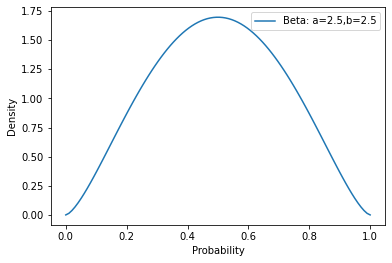

In [3]:
beta_dist(0.5, 5)

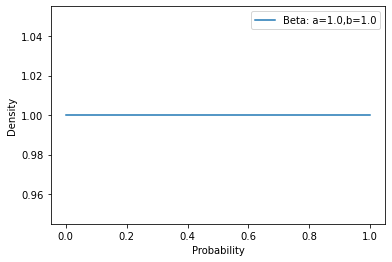

In [4]:
#When theta is 2 we get something totally flat
beta_dist(0.5, 2)

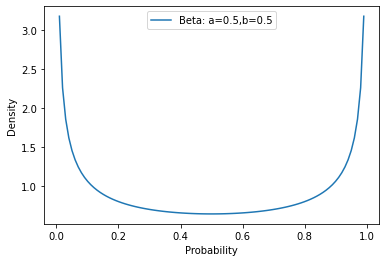

In [5]:
#When theta is less than 2 we get something where the probabilities are more likely to be concentrated 
#at the ends of the interval rather than the mean
beta_dist(0.5, 1)

In [6]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/UCBadmit.csv'), delimiter=";")
    
    return data

In [7]:
data = data_proc()

In [8]:
N = data.applications.values
gid = (data["applicant.gender"]=='female').astype(int).values

In [9]:
data.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


#### The model:
$$A_{i} \sim BetaBinomial(N_{i}, \bar{P_{i}}, \theta)$$

$$logit(\bar{p_{i}})= \alpha_{GID[i]}$$

$$\alpha_{j} \sim Normal(0, 1.5)$$

$$\theta = \phi + 2$$

$$\phi \sim Exponential(1)$$

#### A is the outcome admit, B is the applications and $GID[i]$ is the gender ID. For the prior $\theta$ we want to assume that the dispersion is at least 2, which means flat (see implications of changing theta above). So the exponential distribution has a minimum of zero, if we add 2 to any expo distribution variable then the minimum of the new variable is 2.

In [10]:
with pm.Model() as m12_1:
    a = pm.Normal("a", 0, 1.5, shape=2)
    phi = pm.Exponential("phi", 1.0)
    
    theta = pm.Deterministic("theta", phi+2.0)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a[gid]))
    
    #using definitions for a and b shape parameter as shown in the above beta_dist function
    A = pm.BetaBinomial("A", pbar*theta, (1.0-pbar)*theta, N, observed=data.admit.values)
    
    trace_12_1 = pm.sample(random_seed=8_927)
    
    

<ipython-input-10-026ca15db84b>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_12_1 = pm.sample(random_seed=8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
az.summary(trace_12_1, var_names=["a", "phi", "theta"])

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.441,0.411,-1.234,0.317,0.009,0.007,2145.0,2423.0,1.0
a[1],-0.326,0.410,-1.112,0.421,0.010,0.007,1818.0,2216.0,1.0
phi,1.012,0.765,0.007,2.423,0.015,0.011,2360.0,1515.0,1.0
theta,3.012,0.765,2.007,4.423,0.015,0.011,2360.0,1515.0,1.0


#### The log odds of admission for males a[0] is smaller than for females but the difference is highly uncertain.

In [12]:
difference = trace_12_1["a"][:, 0] - trace_12_1["a"][:, 1]
az.summary({'difference_in_a': difference}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
difference_in_a,-0.115,0.577,-1.199,0.96


#### In our previous notebook on this data we could observe that omitting department ended up misleading our inference since there exists an indirect path from gender through department to admission. However the beta-binomial model is not confounded by this omission. 

#### This is because the model allows each row in the data to have its own unobserved intercept, these intercepts are sampled from the beta distribution with mean $\bar{p_{i}}$ and dispersion $\theta$. Let's look at a plot

Text(0.5, 1.0, 'Distribution of female admission rates')

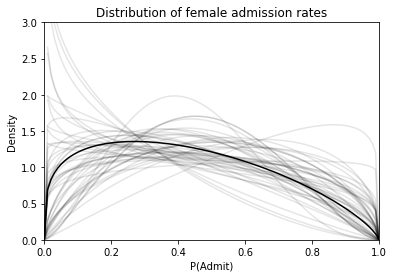

In [13]:
gender_id = 1
x = np.linspace(0, 1, 100)

pbar_mu = logistic(trace_12_1["a"][:, gender_id]).mean()
theta_mu = trace_12_1["theta"].mean()
a = pbar_mu*theta_mu
b = (1.0-pbar_mu)*theta_mu

plt.plot(x, stats.beta.pdf(x, a, b), c='k')

#50 beta draws from the posterior

plt.plot(x, 
         stats.beta.pdf(x[:, np.newaxis], logistic(trace_12_1["a"][:, gender_id])[:50]*trace_12_1["theta"][:50],
                         (1.0-logistic(trace_12_1["a"][:, gender_id])[:50])*trace_12_1["theta"][:50]),
       c='k', alpha=0.1)

plt.xlim(0.0, 1.0)
plt.xlabel("P(Admit)")
plt.ylim(0.0, 3.0)
plt.ylabel("Density")
plt.title("Distribution of female admission rates")


#### The above plot shows 50 combinations of $\bar{p}$ and $\theta$, sampled from the posterior. The thick curve is the beta distribution corresponding the posterior mean. The central tendency is for low probabilities of admission, less than 0.5. But the most plausible distributions allow for departments. that admit most applicants. What the model has done is accommodate the variation among departments—there is a lot of variation! As a result, it is no longer tricked by department variation into a false inference about gender.

#### If we do a posterior validation check we can get a sense of how the beta distribution of probabilities of admission influences predicted counts of applications admitted.

In [14]:
with m12_1:
    posterior_m12_1 = pm.sample_posterior_predictive(trace_12_1, random_seed=8_927)["A"]

posterior_pred_admit = posterior_m12_1/N 

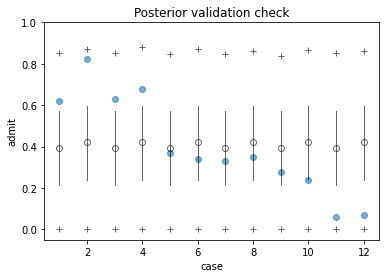

In [15]:
plt.plot(range(1, 13), data.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(range(1, 13), trace_12_1["pbar"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(trace_12_1["pbar"][None, :]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(posterior_pred_admit[None, :]).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

#### The vertical axis shows the predicted proportion admitted, for each case on the horizontal. The blue points show the empirical proportion admitted on each row of the data. The open circles are the posterior mean $\bar{p}$, with 89% percentile interval, and the + symbols mark the 89% interval of predicted counts of admission. There is a lot of dispersion expected here. The model can’t see departments, because we didn’t tell it about them. But it does see heterogeneity across rows, and it uses the beta distribution to estimate and anticipate that heterogeneity.
